# Clustering My Most Played Spotify Songs

After performing further visualizations in R to find any interesting trends in the data, this notebook will be for creating a clustering model for my most played Spotify songs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('FinalSongAnalysisMerged.csv')

In [3]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artistName,trackName,PlayCount
0,0.395,0.848,4,-7.285,0,0.0527,0.00126,0.000500,0.335,0.580,87.619,4,Kansas,Don't Open Your Eyes,101
1,0.599,0.846,5,-6.086,1,0.1980,0.05150,0.000012,0.748,0.875,108.207,4,Kansas,Stay out of Trouble,28
2,0.327,0.851,6,-7.656,0,0.0629,0.00206,0.003700,0.722,0.508,96.377,4,Kansas,Icarus - Borne on Wings of Steel,27
3,0.376,0.853,11,-6.698,0,0.3080,0.01870,0.024900,0.300,0.301,144.403,4,Kansas,How My Soul Cries Out for You,24
4,0.427,0.730,9,-6.173,0,0.0360,0.01800,0.000364,0.218,0.553,106.255,4,Kansas,Miracles out of Nowhere,22


### Review

As I saw in the previous notebook, there is not much correlation between any of the features. Additionally, most songs had very similar features, which is not surprising since it is my most played song.

### Feature Meanings

Danceability: From 0 to 1. How "easy" it is to dance to a song.

Energy: 0 to 1. Represents a perceptual measure of intensity and activity. Higher ---> more energy

Key: Major key of a track {0: C, 1: C#, 2:D, ..., 11: B}

Loudness: Overall loudness of a track in dB. Typically between -60 and 0 dB.

Mode: Major (1) or Minor (0)

Speechiness: 0 to 1. Detects the amount of speech compared to the amount of singing. Higher ---> more speech.

Acousticness: 0 to 1. Measures how acoustic vs. electric. Higher is more acoustic.

Instrumentalness: 0 to 1. The higher, the more likely it is instrumental (no vocals)

Liveness: 0 to 1. Higher means the track is more likely to be recorded live.

Valence: 0 to 1. Positiveness conveyed by a song. The higher the score, the more positive (happy, etc) it is.

Tempo: The quickness of a song. The higher, the more fast-paced.

Time Signature: How the music is being counted. Almost always 4, so this may be unnecessary data (doesn't provide anything).

Play Count: The amount of times played over the past year. (This will not be used in clustering since it is not a feature of a song. I am interested to see if the clusters have any correlation to play count, though, so I will keep it for later)

### Acousticness

The acousticness for most of my songs is very low (almost zero), so I want to make a better visual to see if, at a smaller scale, there is a difference.

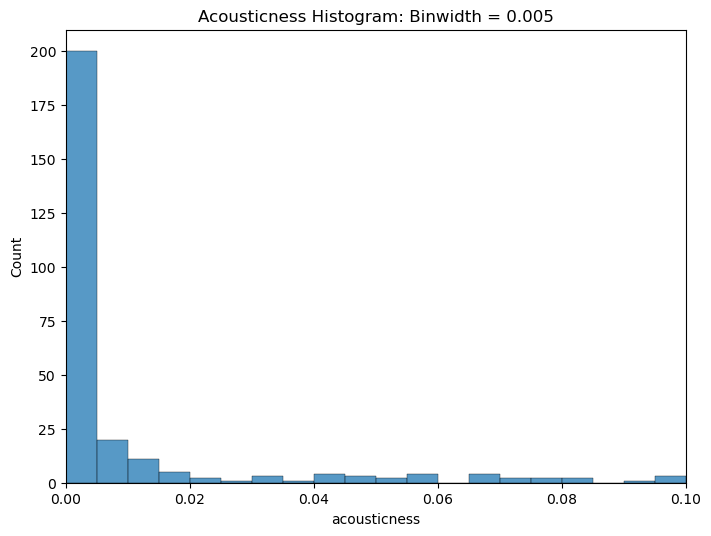

In [9]:
plt.figure(figsize=(8,6),dpi=100)

sns.histplot(data=df, x='acousticness', binwidth=0.005)

plt.title("Acousticness Histogram: Binwidth = 0.005")
plt.xlim(0, 0.1)
plt.show()

As we can see,  around 200 out of 294 songs in the dataset have acousticness between 0 and 0.005. Since the range of acousticness is 0 to 1, this shows that the acousticness feature of most of my songs is basically zero and there really is not much spread over a small range.

### Key and Mode

The main key of a song will often determine the "sound" of a song (not necessarily style), but this can be related to the mode of the song (whether it is in major or minor key).

I want to see if visualizing the keys split on the mode gives any indication of whether a song is in major or minor based on its main key.

In [11]:
df['mode'].value_counts() # value counts of mode for reference

1    192
0    102
Name: mode, dtype: int64

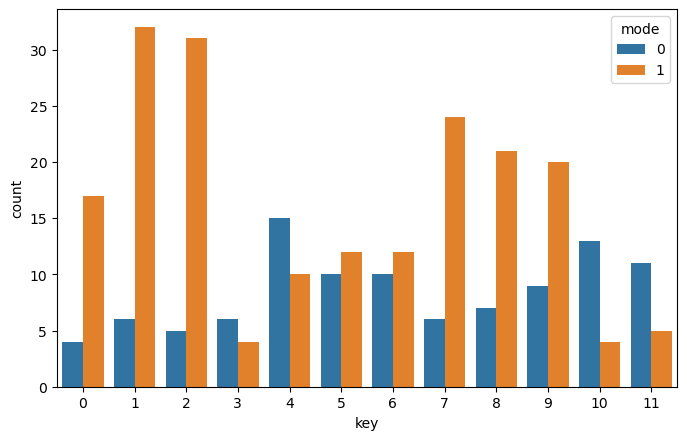

In [13]:
plt.figure(figsize=(8,5), dpi=100)

sns.countplot(data=df, x='key', hue='mode');

As we can see, if the main key of a song is in 0-2 or 7-9, then the song will more likely be played in a major key. However, the rest of the keys are very similar, with some having majority of minor key.

Of note is that there is roughly a 2 to 1 ratio overall of major to minor key, so this could indicate that, if the main key is 0-2 or 7-9 (especially 0-2), then there is a strong indication the song will be played in major.

In [14]:
features_for_cluster = df.columns.drop(['PlayCount', 'artistName', 'trackName'])

X = df[features_for_cluster]

In [15]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.395,0.848,4,-7.285,0,0.0527,0.00126,0.000500,0.335,0.580,87.619,4
1,0.599,0.846,5,-6.086,1,0.1980,0.05150,0.000012,0.748,0.875,108.207,4
2,0.327,0.851,6,-7.656,0,0.0629,0.00206,0.003700,0.722,0.508,96.377,4
3,0.376,0.853,11,-6.698,0,0.3080,0.01870,0.024900,0.300,0.301,144.403,4
4,0.427,0.730,9,-6.173,0,0.0360,0.01800,0.000364,0.218,0.553,106.255,4


In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [45]:
onehot = OneHotEncoder()
scaler = StandardScaler()

preprocessing = ColumnTransformer([
    ('nums', scaler, X.select_dtypes(include='float64').columns), # non-categorical numerical features
    ('cats', onehot, X.select_dtypes(include='int64').columns) # categorical numerical features
])

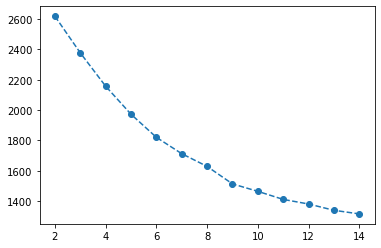

In [57]:
ssd = []

N = 15
for k in range(2, N):
    kmeans_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('kmeans', KMeans(n_clusters=k))
    ])
    
    kmeans_pipeline.fit(X)
    
    inertia = kmeans_pipeline[1].inertia_
    ssd.append(inertia)
    

plt.plot(range(2,N), ssd, 'o--')

It looks like k=9 is a good choice, but because I know my top songs are all relatively similar in genre, I will choose k=6.

In [152]:
kmeans_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('kmeans', KMeans(n_clusters=4))
])

clusters = kmeans_pipeline.fit_predict(X)

cluster_centers = kmeans_pipeline[1].cluster_centers_

In [153]:
df['Cluster'] = clusters

df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artistName,trackName,PlayCount,Cluster
0,0.395,0.848,4,-7.285,0,0.0527,0.00126,0.000500,0.335,0.580,87.619,4,Kansas,Don't Open Your Eyes,101,2
1,0.599,0.846,5,-6.086,1,0.1980,0.05150,0.000012,0.748,0.875,108.207,4,Kansas,Stay out of Trouble,28,2
2,0.327,0.851,6,-7.656,0,0.0629,0.00206,0.003700,0.722,0.508,96.377,4,Kansas,Icarus - Borne on Wings of Steel,27,2
3,0.376,0.853,11,-6.698,0,0.3080,0.01870,0.024900,0.300,0.301,144.403,4,Kansas,How My Soul Cries Out for You,24,1
4,0.427,0.730,9,-6.173,0,0.0360,0.01800,0.000364,0.218,0.553,106.255,4,Kansas,Miracles out of Nowhere,22,2


In [154]:
df.groupby('Cluster').mean().transpose()

Cluster,0,1,2,3
danceability,0.441417,0.364955,0.510865,0.678375
energy,0.806717,0.919721,0.885460,0.514250
key,4.583333,5.108108,5.392638,2.750000
loudness,-6.074750,-4.475703,-5.583037,-10.297250
mode,0.500000,0.675676,0.656442,0.500000
speechiness,0.082483,0.114911,0.069308,0.162475
acousticness,0.024460,0.012710,0.023466,0.494875
instrumentalness,0.532167,0.007514,0.006526,0.000052
liveness,0.229592,0.212185,0.240225,0.309638
valence,0.402167,0.394857,0.573632,0.550000


The above shows the mean values of all the data grouped by the cluster each is in. What may be interesting is making box plots for each grouping (except key, mode, and time_signature since they are discrete) to see if there are interesting difference

In [155]:
df['Cluster'].value_counts()

2    163
1    111
0     12
3      8
Name: Cluster, dtype: int64

As we can see, clusters 0 and 3 are very small.

It may be the case that clusters 0 and 3 picked up on subtle feature differences.

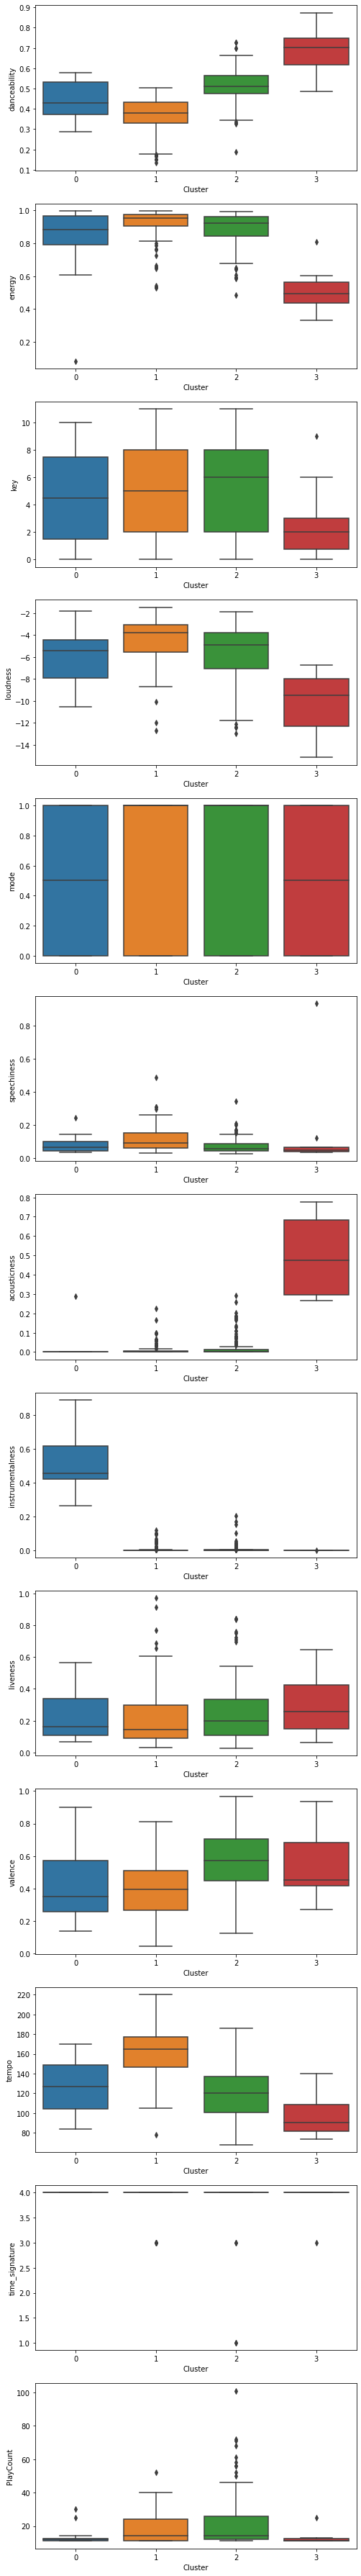

In [156]:
num_feats = df.select_dtypes(include='number').columns.drop(['Cluster'])

N = len(num_feats)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 5*N))

for i in range(N):
    sns.boxplot(data=df, x='Cluster', y=num_feats[i], ax=ax[i])
    

We can see some direct separation with some of the features by cluster. Specifically, I am interested in clusters 2 and 3.

Cluster 3 has higher danceability than the rest, lower energy than the rest, a lower key (this seems interesting as the key feature is distributed rather evenly throughout the 12 of them), higher acousticness, and lower tempo.

Cluster 0 had much higher instrumentalness than the rest.

With the small sample sizes of clusters 0 and 3, it could be a product of one or two songs have very different values, but otherwise being similar to the rest. I will explore them.

Since it is hard to see acousticness, I will do this separately with a better scale.

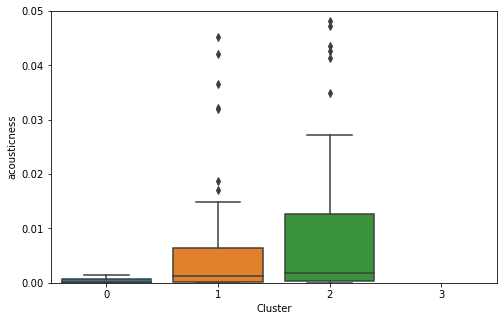

In [157]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=df, x='Cluster', y='acousticness')

plt.ylim(0, 0.05)
plt.show()

Focusing further in on the acousticness feature shows that cluster 0 does have the lowest amount of acousticness.

I will now explore clusters 0 and 3 specifically.

In [158]:
cluster_0 = df[df['Cluster']==0]
cluster_3 = df[df['Cluster']==3]

In [159]:
cluster_0

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artistName,trackName,PlayCount,Cluster
140,0.429,0.9620,4,-5.178,0,0.0673,0.000018,0.261,0.0686,0.285,89.956,4,Rush,Headlong Flight,12,0
141,0.366,0.6060,0,-10.274,1,0.0371,0.000994,0.580,0.0762,0.137,143.183,4,Rush,La Villa Strangiato,11,0
150,0.360,0.9820,5,-3.345,0,0.1440,0.000052,0.391,0.0703,0.139,83.376,4,Sum 41,King Of Contradiction,30,0
156,0.577,0.8540,9,-4.842,1,0.2440,0.001490,0.826,0.2860,0.302,164.149,4,Sum 41,Ride The Chariot To The Devil,25,0
194,0.539,0.8280,4,-9.108,0,0.0350,0.000670,0.421,0.1540,0.562,105.250,4,Metallica,Master of Puppets (Remastered),12,0
227,0.373,0.9400,10,-7.533,1,0.0966,0.000111,0.437,0.4270,0.384,169.684,4,Def Leppard,Stagefright,12,0
237,0.430,0.8670,2,-5.214,0,0.0377,0.000009,0.682,0.1340,0.317,141.924,4,Mötley Crüe,If I Die Tomorrow,14,0
248,0.387,0.8990,0,-2.823,1,0.0473,0.000132,0.467,0.1710,0.595,170.186,4,Grand Funk Railroad,Footstompin' Music,12,0
270,0.288,0.0806,5,-6.558,0,0.0629,0.000017,0.594,0.5630,0.900,118.445,4,Skid Row,Iron Will,11,0
278,0.567,0.6870,9,-10.536,1,0.0435,0.290000,0.426,0.1210,0.625,99.930,4,ZZ Top,Just Got Paid,11,0


In [151]:
df.mean().transpose()

danceability          0.457500
energy                0.885080
key                   5.180272
loudness             -5.313310
mode                  0.653061
speechiness           0.089598
acousticness          0.032273
instrumentalness      0.028178
liveness              0.231093
valence               0.498494
tempo               134.890245
time_signature        3.955782
PlayCount            19.234694
Cluster               2.469388
dtype: float64

Unsurprisingly, because of the small sample size, there are very few reasons why cluster 2 had such different data values for instrumentalness.

Two of the songs here are instrumentals (La Villa Strangiato and Ride the Chariot to the Devil). I find it interesting that Spotify found the instrumentalness of non-instrumental songs to be higher than La Villa Strangiato.

In [150]:
cluster_3

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artistName,trackName,PlayCount,Cluster
91,0.744,0.603,2,-8.169,1,0.0485,0.265,0.000000,0.6350,0.862,86.646,4,Tenacious D,"Don't Blow It, Kage",25,3
92,0.708,0.330,1,-15.167,1,0.9330,0.701,0.000000,0.2590,0.273,129.698,3,Tenacious D,Inward Singing,12,3
166,0.759,0.552,6,-9.536,0,0.0322,0.505,0.000000,0.1650,0.436,101.321,4,"""Weird Al"" Yankovic","Ebay (Parody of ""I Want It That Way"" by the Ba...",11,3
197,0.654,0.448,0,-9.511,1,0.0480,0.301,0.000003,0.0943,0.429,73.500,4,Polar Bear Club,Drifting Thing,11,3
202,0.486,0.487,9,-11.633,0,0.0341,0.445,0.000014,0.0648,0.373,81.972,4,Rainbow,The Temple Of The King,13,3
276,0.510,0.389,2,-14.317,0,0.0384,0.286,0.000398,0.6440,0.621,94.040,4,Eric Clapton,"Layla - Acoustic; Live at MTV Unplugged, Bray ...",11,3
282,0.873,0.808,0,-6.729,0,0.0466,0.777,0.000000,0.3570,0.933,139.676,4,Beastie Boys,Girls,11,3
285,0.693,0.497,2,-7.316,1,0.1190,0.679,0.000000,0.2580,0.473,81.308,4,Queen,We Will Rock You,11,3


Cluster 3's data suggested that this should be the grouping of more danceable, slower paced, acoustic music. I definitely see that the instrumentalness is zero for most of these songs, and I would agree that, overall, these songs are not the most typical songs I listen to.

### Conclusion

Overall, I am not surprised to see the overall statistics. Since all the songs are rather similar (high energy, tempo, etc), the clusters 1 and 2, which contained most of the songs, are very similar with the only difference being the tempo feature.